In [1]:
%load_ext nb_black
from IPython.core.debugger import set_trace

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

#### Read CSV

In [2]:
df = pd.read_csv(
    f"../data/IMDb Movies.csv", encoding="ISO-8859-1", error_bad_lines=False
)

<IPython.core.display.Javascript object>

#### K-means

K-means clustering is a clustering method that aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest cluster center (cluster centroid).

The standard k-means algorithm is only applicable to numeric data and isn't directly applicable to categorical data for various reasons. 

One being that as the sample space for categorical data is discrete, an Euclidean distance function on such a space is not meaningful. 

![](https://media.geeksforgeeks.org/wp-content/uploads/20190812011831/Screenshot-2019-08-12-at-1.09.42-AM.png)

How does it work ?

If we would be given the centroids we would assign each observation to to the centroid that is closest.

But since we aren't given the centroids' locations, we start by placing the centroids randomly in the feature space and labelling the observations (assigning them to the closest centroid).

Then we update the locations of the centroids and label the observations again. And we repeat this procedure as many times as needed until the centroids stop moving.

![](https://www.researchgate.net/profile/Rumdeep_Grewal2/publication/276494113/figure/fig2/AS:391847961743364@1470435242664/K-means-clustering-A-Starting-with-three-randomly-placed-centroids-green-B-Next.png)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

<IPython.core.display.Javascript object>

In [4]:
df.head(2)

imdb_title_id                        title               original_title  \
0     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
1     tt0001892              Den sorte drÃ¸m              Den sorte drÃ¸m   

   year date_published                    genre  duration           country  \
0  1906     1906-12-26  Biography, Crime, Drama        70         Australia   
1  1911     1911-08-19                    Drama        53  Germany, Denmark   

  language      director  ...  \
0      NaN  Charles Tait  ...   
1      NaN     Urban Gad  ...   

                                              actors  \
0  Elizabeth Tait, John Tait, Norman Campbell, Be...   
1  Asta Nielsen, Valdemar Psilander, Gunnar Helse...   

                                         description avg_vote votes  budget  \
0  True story of notorious Australian outlaw Ned ...      6.1   537  $ 2250   
1  Two men of high rank are both wooing the beaut...      5.9   171     NaN   

   usa_gross_income worlwide_gross_income metascore reviews_from_users  \
0               NaN                   NaN       NaN                7.0   
1               NaN                   NaN       NaN                4.0   

   reviews_from_critics  
0                   7.0  
1                   2.0  

[2 rows x 22 columns]

<IPython.core.display.Javascript object>

In [5]:
df.dtypes

imdb_title_id             object
title                     object
original_title            object
year                       int64
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

<IPython.core.display.Javascript object>

Let's first start with only one feature

In [22]:
features = ["duration", "year", "votes", "reviews_from_users"]

# Select one feature
data = df[features].copy()
data.fillna(-999, inplace=True)
data = data.values
print(data)

[[  70. 1906.  537.    7.]
 [  53. 1911.  171.    4.]
 [ 100. 1912.  420.   24.]
 ...
 [ 111. 2019.  604. -999.]
 [ 130. 2019.  369. -999.]
 [  98. 2019.  190. -999.]]


<IPython.core.display.Javascript object>

Scale the input feature

In [23]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
print(data)

[[-1.20718569 -3.62648867 -0.17019941  0.16311997]
 [-1.87859082 -3.41808705 -0.17721062  0.15406555]
 [-0.0223531  -3.37640673 -0.1724407   0.21442836]
 ...
 [ 0.41208551  1.08338788 -0.16891594 -2.87312953]
 [ 1.16247948  1.08338788 -0.17341767 -2.87312953]
 [-0.10134194  1.08338788 -0.17684665 -2.87312953]]


<IPython.core.display.Javascript object>

Since we don't have prior information about this dataset we don't know how to set the number of clusters to best split this data.

We therefore need to find the optimal number of clusters.

For that we can compute the model's inertia which is the mean squared distance between each observation and it's centroid.

By default the Kmeans algorithm runs n times and keeps the model with the lowest inertia.

So theoretically the best number of clusters can be defined by the model that has the lowest inertia right?

Well no as the more clusters we have, the closer each instance will be to it's closest centroid and the lower the inertia will be. 

If we would have a number of clusters equal to the number of observations, then the inertia would be 0 and that doesn't help with anything.

So we need to select the number of clusters using the elbow method.


In [24]:
%%time
n_cluster = range(1, 21)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

f = plt.figure(1, figsize=(16,6))
plt.plot(scores)
_ = plt.xticks(n_cluster)

CPU times: user 3min 14s, sys: 1min 33s, total: 4min 48s
Wall time: 21.9 s


<IPython.core.display.Javascript object>

We plot the explained variation as a function of the number of clusters, and pick the *elbow* of the curve as the number of clusters to use.

Another option to get the best number of clusters is to use a silhouette score. But it's computationally expensive and we'll stick to the elbow method for practical reasons.

In [9]:
%%time
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4).fit_predict(data)
print(silhouette_score(data, kmeans))

0.5356016085980859
CPU times: user 1min 16s, sys: 15.2 s, total: 1min 31s
Wall time: 1min 26s


<IPython.core.display.Javascript object>

Get the best number of clusters based on the elbow method, where the difference between scores is smaller than the 90% percentile.


In [25]:
scores = np.array(scores)
dif_scores = scores / scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)

16


<IPython.core.display.Javascript object>

Let's check the first observation

In [26]:
preds = KMeans(n_clusters=n_clusters).fit_predict(data)
print(f"First observation's cluster: {preds[0]}")

First observation's cluster: 3


<IPython.core.display.Javascript object>

In [27]:
df = pd.DataFrame(df)
df["cluster"] = preds

outliers = [
    x
    for x in zip(
        df["cluster"].value_counts().iloc[-2:].index,
        df["cluster"].value_counts().iloc[-2:].values,
    )
]

<IPython.core.display.Javascript object>

In [28]:
df["cluster"].value_counts()

0     22367
10    12996
4     12867
8      9510
3      6272
2      4160
5      4141
9      3023
13     1996
15     1773
11     1138
1       635
14      203
12      155
6        36
7         1
Name: cluster, dtype: int64

<IPython.core.display.Javascript object>

In [29]:
# first item in tuple is the predicted cluster, the second is the number of observations
outliers

[(6, 36), (7, 1)]

<IPython.core.display.Javascript object>

In [32]:
# get only the categories that contain a number of observations that in the lower quantile of 10%
clusters = [
    x[0]
    for x in outliers
    if x[1] < np.quantile(df["cluster"].value_counts().values, 0.10)
]

<IPython.core.display.Javascript object>

In [33]:
clusters

[6, 7]

<IPython.core.display.Javascript object>

In [34]:
for c in clusters:
    print(df[df.cluster == c][features])

       duration  year    votes  reviews_from_users
14943       175  1972  1482143              3362.0
15954       202  1974  1032047               857.0
17583       121  1977  1147198              1688.0
18733       124  1980  1078687              1098.0
25473       118  1991  1169794              1141.0
26817       195  1993  1120236              1642.0
27245       142  1994  1662528              2050.0
27558       154  1994  1695085              2766.0
27628       142  1994  2159628              7029.0
28459       127  1995  1327366              1294.0
30262       194  1997   980680              2721.0
30427       189  1999  1050082              1571.0
30456       178  2001  1548863              5218.0
30510       169  1998  1143733              2452.0
31375       136  1999  1554261              4069.0
31627       139  1999  1725365              3496.0
33198       201  2003  1533574              3528.0
33199       179  2002  1387154              2488.0
33363       122  1999  1009384 

<IPython.core.display.Javascript object>

In [18]:
df[features].describe()

duration
count  81273.000000
mean     100.565981
std       25.320189
min       40.000000
25%       88.000000
50%       96.000000
75%      108.000000
max     3360.000000

<IPython.core.display.Javascript object>

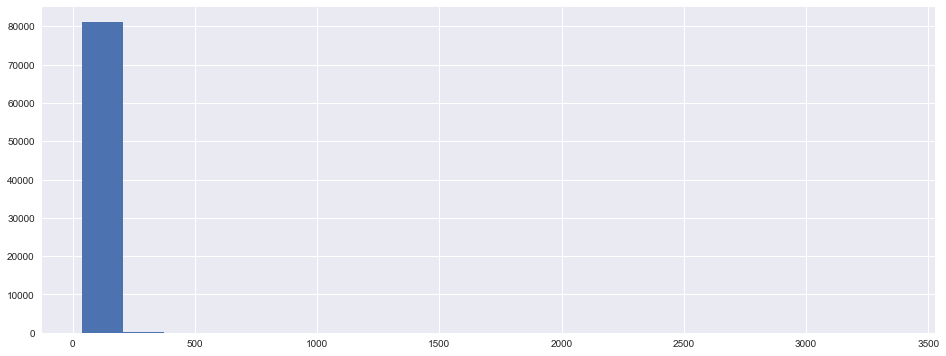

<IPython.core.display.Javascript object>

In [20]:
f = plt.figure(1, figsize=(16, 6))
_ = plt.hist(df[features].values, bins=20)

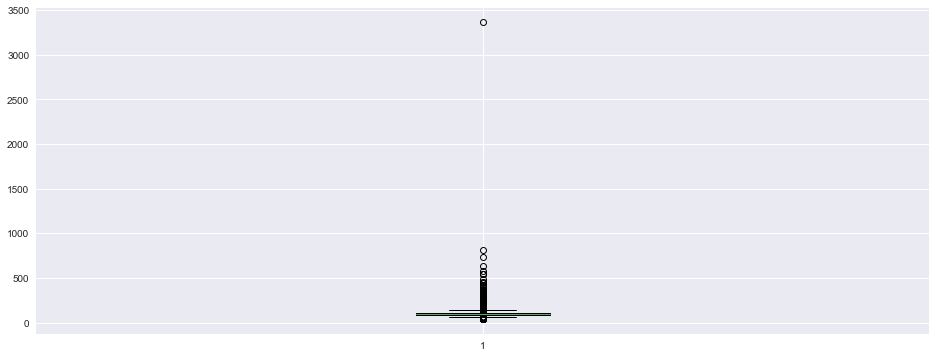

<IPython.core.display.Javascript object>

In [21]:
f = plt.figure(1, figsize=(16, 6))
_ = plt.boxplot(df[features].values)